In [54]:
# Imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.cluster import KMeans
from textwrap import wrap


In [56]:
# Load SPD neighborhood boundaries (GeoJSON)
gdf = gpd.read_file("../data/raw/spd_dispatch_neighborhoods.geojson")

# Load merged 911 call dataset
df = pd.read_csv("../data/processed/merged_spd_weather.csv")


C:\Users\aniru\AppData\Local\Temp\ipykernel_35916\2372448981.py:5: DtypeWarning: Columns (17,18,19,20,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/merged_spd_weather.csv")


In [57]:
# Adjust column name in GeoJSON if needed (update this as appropriate)
gdf = gdf.rename(columns={"neighborhood": "Neighborhood"})  # Replace with actual column name
gdf['Neighborhood'] = gdf['Neighborhood'].str.lower().str.strip()

# Standardize names in the call dataset
df['Neighborhood'] = df['Dispatch Neighborhood'].str.lower().str.strip()


In [58]:
# Aggregate call volume per neighborhood
call_counts = df['Neighborhood'].value_counts().reset_index()
call_counts.columns = ['Neighborhood', 'call_count']

# Merge with GeoDataFrame
gdf_merged = gdf.merge(call_counts, on='Neighborhood', how='left')
gdf_merged['call_count'] = gdf_merged['call_count'].fillna(0)
gdf_merged = gdf_merged.to_crs(epsg=3857)


In [59]:

def place_neighborhood_labels(ax, gdf, name_col='Neighborhood',
                              length_threshold=20,
                              area_threshold=1e8,
                              max_wrap_width=14,
                              label_box_size=(4000, 2000),
                              offset_step=2000,
                              offset_layers=6):
    """
    Place neighborhood labels with smart overlap avoidance and optional leader lines.
    """

    existing_bboxes = []

    def overlaps_existing(x, y, width, height):
        new_box = plt.Rectangle((x - width / 2, y - height / 2), width, height)
        for box in existing_bboxes:
            if new_box.get_bbox().overlaps(box.get_bbox()):
                return True
        existing_bboxes.append(new_box)
        return False

    def generate_offsets(step, layers):
        angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 directions
        offsets = []
        for r in range(1, layers + 1):
            for angle in angles:
                dx = np.cos(angle) * step * r
                dy = np.sin(angle) * step * r
                offsets.append((dx, dy))
        return offsets

    for idx, row in gdf.iterrows():
        geom = row['geometry']
        if geom.is_empty or geom.centroid.is_empty:
            continue

        name = row[name_col]
        if not isinstance(name, str):
            continue

        # Shorten long names
        if len(name) > length_threshold:
            display_name = name[:4].title() + "..."
        else:
            display_name = name.title()

        wrapped_name = "\n".join(wrap(display_name, width=max_wrap_width))

        x_anchor, y_anchor = geom.representative_point().coords[0]
        area = geom.area

        needs_external_label = len(name) > length_threshold or area < area_threshold

        if needs_external_label:
            placed = False
            for dx, dy in generate_offsets(offset_step, offset_layers):
                x_label = x_anchor + dx
                y_label = y_anchor + dy
                point = Point(x_label, y_label)

                if overlaps_existing(x_label, y_label, *label_box_size):
                    continue
                if gdf.contains(point).any():  # Avoid placing inside the map
                    continue

                # Draw leader line
                ax.plot([x_anchor, x_label], [y_anchor, y_label], color='gray', linewidth=0.5)
                ax.text(x_label, y_label, wrapped_name,
                        fontsize=8, ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.85))
                placed = True
                break

            if not placed:
                # Fallback: place inside
                ax.text(x_anchor, y_anchor, wrapped_name,
                        fontsize=8, ha='center', va='center')
        else:
            # Internal label
            ax.text(x_anchor, y_anchor, wrapped_name,
                    fontsize=8, ha='center', va='center')


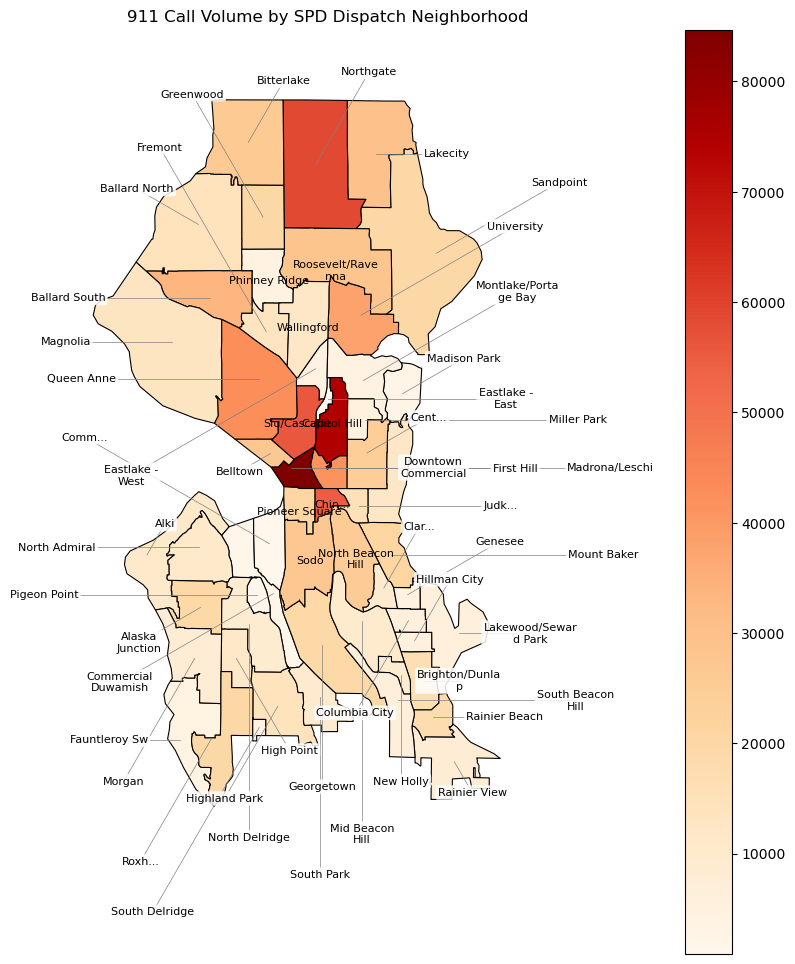

In [60]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_merged.plot(column='call_count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True)

# Add neighborhood labels
place_neighborhood_labels(ax, gdf_merged)

plt.title("911 Call Volume by SPD Dispatch Neighborhood")
plt.axis('off')
plt.show()


In [50]:
# Cluster based on call volume (can expand later with more features)
kmeans = KMeans(n_clusters=4, random_state=0)
gdf_merged['cluster'] = kmeans.fit_predict(gdf_merged[['call_count']])


c:\Users\aniru\miniforge3\envs\seattle911\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


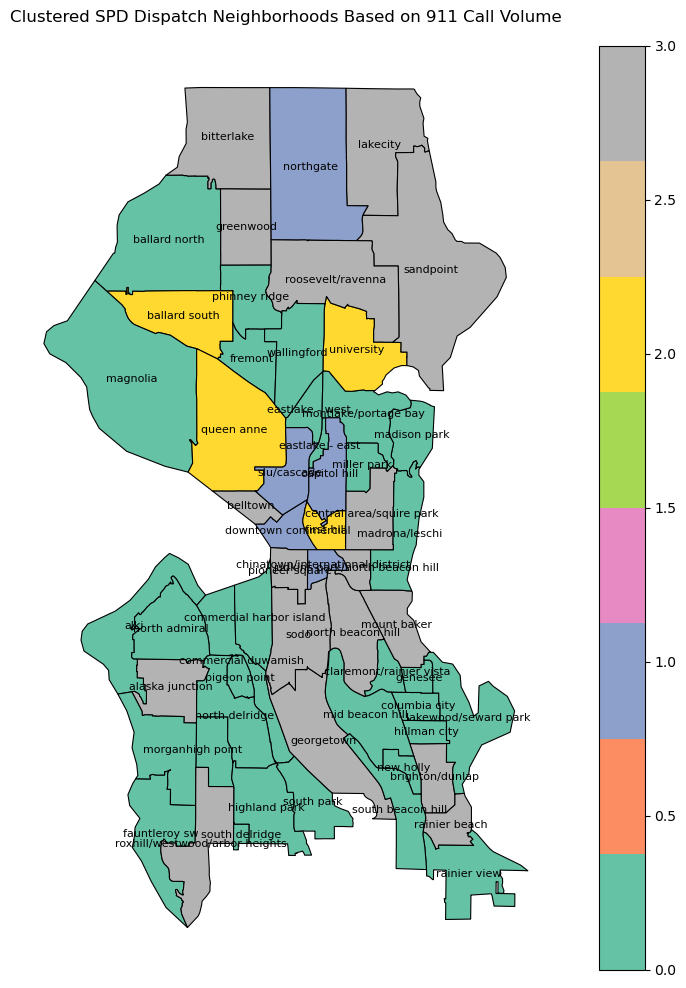

In [51]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf_merged.plot(column='cluster', cmap='Set2', linewidth=0.8, ax=ax, edgecolor='black', legend=True)

# Add neighborhood labels
for idx, row in gdf_merged.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, row['Neighborhood'], fontsize=8, ha='center', va='center')

plt.title("Clustered SPD Dispatch Neighborhoods Based on 911 Call Volume")
plt.axis('off')
plt.show()


In [ ]:
# Save GeoJSON with cluster info
gdf_merged.to_file("../data/processed/clustered_dispatch_neighborhoods.geojson", driver="GeoJSON")


In [53]:
import folium
from folium import Choropleth, LayerControl, FeatureGroup
from folium.plugins import HeatMap
from folium.features import GeoJson, GeoJsonTooltip

# Convert geometry to EPSG:4326 for folium
gdf_web = gdf_merged.to_crs(epsg=4326)

# Create base map
m = folium.Map(location=[47.6, -122.33], zoom_start=12, tiles='CartoDB positron')

# === 1. Choropleth by Call Volume ===
volume_layer = FeatureGroup(name="Choropleth: Call Volume")

folium.GeoJson(
    gdf_web,
    name="Call Volume",
    tooltip=GeoJsonTooltip(fields=['Neighborhood', 'call_count'],
                           aliases=['Neighborhood:', 'Calls:'],
                           localize=True),
    style_function=lambda feature: {
        'fillColor': '#ffeda0' if feature['properties']['call_count'] == 0 else
                     '#feb24c' if feature['properties']['call_count'] < 500 else
                     '#f03b20',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }
).add_to(volume_layer)

volume_layer.add_to(m)

# === 2. Choropleth by Cluster ===
cluster_layer = FeatureGroup(name="Choropleth: Clusters")

folium.GeoJson(
    gdf_web,
    name="Clusters",
    tooltip=GeoJsonTooltip(fields=['Neighborhood', 'cluster'],
                           aliases=['Neighborhood:', 'Cluster:'],
                           localize=True),
    style_function=lambda feature: {
        'fillColor': ['#1b9e77', '#d95f02', '#7570b3', '#e7298a'][feature['properties']['cluster'] % 4],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    }
).add_to(cluster_layer)

cluster_layer.add_to(m)

# === 3. Heatmap of Call Locations ===
heat_layer = FeatureGroup(name="Heatmap: Call Density")

# Use only rows with valid coordinates
heat_df = df[['Latitude', 'Longitude']].dropna()
heat_data = heat_df.values.tolist()

HeatMap(heat_data, radius=8, blur=12, min_opacity=0.2).add_to(heat_layer)

heat_layer.add_to(m)

# Add layer control
LayerControl().add_to(m)

# Export to HTML
m.save("../data/interactive_seattle_911_fullmap.html")


KeyError: "None of [Index(['Latitude', 'Longitude'], dtype='object')] are in the [columns]"